In [59]:
from IPython.display import display
import graphviz
from matplotlib import pyplot as plt
from collections import defaultdict 
import random

BEGIN_TOKEN = "___BEGIN__"
END_TOKEN = "___END__"


class Config(object):
    def __init__(self, **kwargs):
        for k, v in kwargs.items():
            setattr(self, k, v)

class NGramModel(object):
    def __init__(self, inputSequences, contextSize, model=None):
        '''
        Creates an n-gram model of the given inputSequences
        The input sequences should be an array of arrays.
        Internally, each array has contextSize BEGIN_TOKEN appended to the start,
        and a single END_TOKEN appended to the end,
        then n-gram analysis is done.
        contextSize=1 is bigram
        contextSize=2 is trigram
        etc.
        '''
        self.contextSize = contextSize
        if model is None:
            self.model = buildNGramModel(inputSequences=inputSequences, contextSize=contextSize)
        else:
            self.model = model
    def gen(self):
        '''
        This function is a generator that can be used to generate samples from the trained nGram model
        It will stop once it hits an end token, meaning that it could go on for a very long time
        '''
        context = [BEGIN_TOKEN]*self.contextSize
        curToken = context[-1]
        while True:
            nextWordOptions = list(self.model[tuple(context)].items())
            words = [nextWord for (nextWord, count) in nextWordOptions]
            counts = [count for (nextWord, count) in nextWordOptions]
            curToken = random.choices(words, weights=counts, k=1)[0] # for lower then python 3.6 you'll need to implement custom weighted choice here
            context = context[1:] + [curToken]
            if curToken == END_TOKEN: break
            # we haven't reached end token, return token and continue generating
            yield curToken
    def __len__(self):
        '''
        Number of different types of context tuples
        '''
        return len(self.model)
        

def buildNGramModel(inputSequences, contextSize):
    '''
    Creates a dictionary of [contextTuple][nextWord] = numOfTimesSeen
    Where contextTuple is of length contextSize, so 
    contextSize=1 is bigram
    contextSize=2 is trigram
    etc.
    Every sequence is automatically given contextSize*[BEGIN_TOKEN] at the start, and an [END_TOKEN] at the end
    '''
    counts = defaultdict(lambda : defaultdict(int)) # default dict of default dict
    for sequence in inputSequences:
        context = [BEGIN_TOKEN]*contextSize
        actualSequence = sequence + [END_TOKEN]
        for word in actualSequence:
            counts[tuple(context)][word] += 1 # because it's a default dict, it'll create entries if they don't exist
            context = context[1:] + [word]
    # convert default dicts to regular dict
    return dict([(contextTuple, dict(nextWordDict)) for (contextTuple, nextWordDict) in counts.items()])


def generateTextWithMaxLen(model, maxSampleLen):
    '''
    Generates text that isn't allowed to be longer than the given length
    If the model doesn't stop generating before that length, we throw out the sequence and make a new one
    Warning: if maxSampleLen is too small, this could loop forever
    '''
    resultSent = list(model.gen())
    while len(resultSent) > maxSampleLen:
        resultSent = list(model.gen())
    return resultSent


def generateDataset(model, maxSampleLen, minTotalGeneratedTokens):
    '''
    Generates samples of text from the given markov chain until the total
    number of tokens generated is more than minTotalGeneratedTokens.
    (If a sample generated is longer than maxSampleLen, it is ignored)
    '''
    totalChars = 0
    allSamples = []
    while totalChars < minTotalGeneratedTokens:
        nextData = generateTextWithMaxLen(model, maxSampleLen)
        allSamples.append(nextData)
        totalChars += len(nextData)
    return allSamples

def runExperiment(config, initialDataset, numSteps, contextSize, maxSampleLen, minTotalGeneratedTokens, debug=False):
    '''
    Runs an experiment where we generate numSamples of text, each of length sampleLen
    Then we use that to train a new markovify model (bigram=stateSize:1, trigram=stateSize:2, etc.)
    We repeat this process numSteps times, and return an array with the model after each step
    '''
    model = NGramModel(initialDataset, contextSize=contextSize)
    models = []
    config.initialModel = model
    for t in range(numSteps):
        try:
            if debug: print(t, numSteps, len(model), differenceInBigrams(config.initialModel, model))
            if config.storeHistory:
                models.append(model)
            dataset = generateDataset(model, maxSampleLen=maxSampleLen, minTotalGeneratedTokens=minTotalGeneratedTokens-config.tokensFromOriginalModel)
            # data from original
            dataset += generateDataset(config.initialModel, maxSampleLen=maxSampleLen, minTotalGeneratedTokens=config.tokensFromOriginalModel)
            prevModel = model
            model = NGramModel(dataset, contextSize=contextSize)
            model = interpolateModels(prevModel, model, config.momentum)
        except:
            # debugging info if you are running into errors
            # display(modelToDot(models[-1]))
            # display(modelToDot(model))
            # print(t)
            raise
    return models

def loopThroughEdgeCounts(model):
    '''
    # model chain stores counts as chain.model[(tuple, of, context)][nextWord]
    # so we need to connect edges between (tuple, of, context) and (of, context, nextWord)
    # so this loops through and returns each
    (tuple, of, context), (of, context, nextWord), transitionCount
    '''
    for keyTuple, outputDict in model.model.items():
        keyTupleList = list(keyTuple)
        for outputNode, transitionPr in outputDict.items():
            connectToNodeList = keyTupleList[1:] + [outputNode]
            yield (keyTuple, tuple(connectToNodeList), transitionPr)

def modelToDot(model):
    '''
    Converts a n-gram model into a dot graph that displays the transition counts
    '''
    dot = graphviz.Digraph()
    # it stores probabilities as chain.model[(tuple, of, context)][nextWord]
    # so we need to connect edges between (tuple, of, context) and (of, context, nextWord)
    # made utility function loopThroughEdgeCounts that loops through these for us
    for keyTuple, outputDict in model.model.items():
        dot.node(" ".join(list(keyTuple)))
    for tupleIn, tupleOut, transitionCount in loopThroughEdgeCounts(model):
        dot.edge(" ".join(tupleIn), " ".join(tupleOut), label=str(transitionCount))
    return dot

def modelHistoryToGraphs(modelHistory):
    '''
    Converts a n-gram model history into a dict with [(tupleIn, tupleOut)] = arrOfTransitionCounts
    If a graph doesn't contain a given (tupleIn, tupleOut), a zero is placed in that position
    '''
    edges = dict()
    # loop through all models and get all edges
    for model in modelHistory:
        for tupleIn, tupleOut, transitionCount in loopThroughEdgeCounts(model):
            edge = (tupleIn, tupleOut)
            if not edge in edges:
                edges[edge] = []
    
    # for each edge, construct a history graph of transition counts
    for model in modelHistory:
        # append a zero to the end of every pair, this ensures if our model doesn't have it it still gets noted
        for edge, arr in edges.items():
            arr.append(0)
        # for every pair our model has, overwrite those zeros at the end with the actual transition count
        for tupleIn, tupleOut, transitionCount in loopThroughEdgeCounts(model):
            edge = (tupleIn, tupleOut)
            # overwrite last value to our transition count
            edges[edge][-1] = transitionCount
    return edges

def printModelHistoryAsGraphs(modelHistory):
    '''
    Converts a markovify model history into a dict with [(tupleIn, tupleOut)] = arrOfTransitionCounts
    If a graph doesn't contain a given (tupleIn, tupleOut), a zero is placed in that position
    Then this history is plotted as graphs, for each tuple
    Warning, if you have a lot of tuples this could get slow
    '''
    graphs = modelHistoryToGraphs(modelHistory)
    for edgeTuple, historyOfCounts in graphs.items():
        plt.plot(historyOfCounts)
        plt.title(str(edgeTuple))
        plt.show()
        

def getNormalizedPrs(nextWordCounts):
    if len(nextWordCounts) == 0: return defaultdict(int)
    total = sum([count for (nextWord, count) in nextWordCounts.items()])
    if total == 0: # if they are all zero, assume uniform
        normalizedPrsArr = [(nextWord, 1.0/len(nextWordCounts)) for (nextWord, count) in nextWordCounts.items()]
    else:
        normalizedPrsArr = [(nextWord, count/float(total)) for (nextWord, count) in nextWordCounts.items()]
    normalizedPrs = defaultdict(int)
    for nextWord, pr in normalizedPrsArr:
        normalizedPrs[nextWord] = pr
    return normalizedPrs


def interpolateModels(model1, model2, p):
    resultModel = defaultdict(lambda: defaultdict(float))
    for context, nextWordDict in model1.model.items():
        for nextWord, count in nextWordDict.items():
            resultModel[context][nextWord] += count*p
    for context, nextWordDict in model2.model.items():
        for nextWord, count in nextWordDict.items():
            resultModel[context][nextWord] += count*(1-p)
    return NGramModel(inputSequences=None, contextSize=model1.contextSize, model=resultModel)

        
def differenceInBigrams(model1, model2):
    allContexts = set(model1.model.keys()) | set(model2.model.keys())
    sumDifferences = 0.0
    totalCount = 0
    for context in allContexts:
        if context in model1.model: model1NextWords = getNormalizedPrs(model1.model[context])
        else: model1NextWords = defaultdict(int)
            
        if context in model2.model: model2NextWords = getNormalizedPrs(model2.model[context])
        else: model2NextWords = defaultdict(int)
        allNextWords = set(model1NextWords.keys()) | set(model2NextWords.keys())
        for nextWord in allNextWords:
            sumDifferences += abs(model1NextWords[nextWord] - model2NextWords[nextWord])
            totalCount += 1
    avgDifferences = sumDifferences / totalCount
    return avgDifferences
        
        
        
def printOutputGenerations(model, maxSampleLen, minTotalGeneratedTokens):
    '''
    Print the generated dataset of the model
    '''
    dataset = generateDataset(model, maxSampleLen=maxSampleLen, minTotalGeneratedTokens=minTotalGeneratedTokens)
    return "\n".join([" ".join(sample) for sample in dataset])
        
def runAndVisualizeExperiment(config, initialDataset, printRange, numSteps, contextSize, maxSampleLen, minTotalGeneratedTokens, debug=False):
    '''
    Runs an experiment where we generate at least minTotalGeneratedTokens tokens per step worth of samples
    (rejecting individual samples that are longer than maxSampleLen)
    Then we use that to train a new n-gram model (bigram=contextSize:1, trigram=contextSize:2, etc.)
    We repeat this process numSteps times, and return an array with the models after each step
    printRange is which models we actually want to visualize as dot models (for example, [0,-1] will display the first and last)
    This will also print a graph of the history of each transition pr over time
    '''
    modelHistory = runExperiment(config, initialDataset=initialDataset, numSteps=numSteps, contextSize=contextSize, maxSampleLen=maxSampleLen, minTotalGeneratedTokens=minTotalGeneratedTokens, debug=debug)
    for i in printRange:
        print(i, "model:")
        display(modelToDot(modelHistory[i]))
        print(printOutputGenerations(modelHistory[i], minTotalGeneratedTokens=30, maxSampleLen=maxSampleLen))
    printModelHistoryAsGraphs(modelHistory[1:]) # don't print first one cause its counts are usually very different
    return modelHistory
    


0 3000 4 0.0
1 3000 4 0.0035232798720609554
2 3000 4 0.006693225139190835
3 3000 4 0.009568865154033197
4 3000 4 0.013497161536978091
5 3000 4 0.01592269688885862
6 3000 4 0.014212787249900976
7 3000 4 0.01629565258791013
8 3000 4 0.012349610425836932
9 3000 4 0.019270881237675435
10 3000 4 0.02124052118603472
11 3000 4 0.02283836860537036
12 3000 4 0.026263284315999863
13 3000 4 0.026154805937475583
14 3000 4 0.029338787270240044
15 3000 4 0.0246570346769663
16 3000 4 0.025210618614706935
17 3000 4 0.028404900848027763
18 3000 4 0.03183150584101869
19 3000 4 0.029769531632602937
20 3000 4 0.027730479231736768
21 3000 4 0.025931942065576315
22 3000 4 0.029995946927173275
23 3000 4 0.03141270173622669
24 3000 4 0.03463637819846926
25 3000 4 0.036506115353838214
26 3000 4 0.03520538583733819
27 3000 4 0.03366866078345189
28 3000 4 0.03020259417725136
29 3000 4 0.033163249507681486
30 3000 4 0.0323427135379519
31 3000 4 0.030508467995258824
32 3000 4 0.034685552807813505
33 3000 4 0.03630

269 3000 4 0.10083099812571744
270 3000 4 0.10119908646952681
271 3000 4 0.10240322951789807
272 3000 4 0.10050329802447935
273 3000 4 0.09677707772783295
274 3000 4 0.09614476674770289
275 3000 4 0.09991749191784798
276 3000 4 0.10158052113132571
277 3000 4 0.10596978730051564
278 3000 4 0.10925525964583976
279 3000 4 0.10548871112099778
280 3000 4 0.10790585581422561
281 3000 4 0.11329280921088011
282 3000 4 0.11278301777655941
283 3000 4 0.11405717214001956
284 3000 4 0.1178527081418766
285 3000 4 0.1143202772238754
286 3000 4 0.11108725835732883
287 3000 4 0.11591019088584964
288 3000 4 0.11336305195321404
289 3000 4 0.10825290637805288
290 3000 4 0.10770901300792607
291 3000 4 0.10793587013204524
292 3000 4 0.1059152325161122
293 3000 4 0.1113180598821697
294 3000 4 0.11360949712963385
295 3000 4 0.11584532454964615
296 3000 4 0.11569615597783639
297 3000 4 0.11410116048350366
298 3000 4 0.11711143146912027
299 3000 4 0.12038994958154833
300 3000 4 0.12310661345416017
301 3000 4 0

538 3000 4 0.12801085651113323
539 3000 4 0.12583947335950996
540 3000 4 0.12529969834193133
541 3000 4 0.12595845399714475
542 3000 4 0.1251988587109756
543 3000 4 0.12816772543445795
544 3000 4 0.12708660817987721
545 3000 4 0.1298939003119446
546 3000 4 0.12595562578065866
547 3000 4 0.12426988006124058
548 3000 4 0.1220143037400682
549 3000 4 0.12271630883631396
550 3000 4 0.12598867875953712
551 3000 4 0.12857372402231343
552 3000 4 0.13133575936381553
553 3000 4 0.13453124321740936
554 3000 4 0.1310599356909451
555 3000 4 0.12835466523197298
556 3000 4 0.12829107201042686
557 3000 4 0.12640661048646237
558 3000 4 0.12497881405530832
559 3000 4 0.12345477363637171
560 3000 4 0.12859252440386618
561 3000 4 0.1315041357622732
562 3000 4 0.1312799708548136
563 3000 4 0.13149033470558308
564 3000 4 0.13615475470130872
565 3000 4 0.13377683736151835
566 3000 4 0.1281454023035541
567 3000 4 0.12743440974149292
568 3000 4 0.1289377062801319
569 3000 4 0.12720991920010666
570 3000 4 0.123

809 3000 4 0.13213181132129792
810 3000 4 0.13725504054475887
811 3000 4 0.13943454256668272
812 3000 4 0.14239653155018717
813 3000 4 0.13893956162542173
814 3000 4 0.1405071826198628
815 3000 4 0.14076793901745066
816 3000 4 0.1406850480862162
817 3000 4 0.13540788460761835
818 3000 4 0.13298056389492752
819 3000 4 0.13164825574719372
820 3000 4 0.13232915001665002
821 3000 4 0.1275274493737599
822 3000 4 0.12785585904194263
823 3000 4 0.12172263651745885
824 3000 4 0.11679127609115143
825 3000 4 0.11484885577111698
826 3000 4 0.11392650154576446
827 3000 4 0.1147039720702031
828 3000 4 0.1116705912288162
829 3000 4 0.11083428267638794
830 3000 4 0.10889415812477075
831 3000 4 0.1083487124798859
832 3000 4 0.10241776972046732
833 3000 4 0.09978357518898737
834 3000 4 0.09527506415221595
835 3000 4 0.09762026771271287
836 3000 4 0.09312927358893573
837 3000 4 0.09025769515662715
838 3000 4 0.08513031621396597
839 3000 4 0.08823666582330136
840 3000 4 0.09184596118917183
841 3000 4 0.0

1078 3000 4 0.1103925472122576
1079 3000 4 0.11390137837198464
1080 3000 4 0.11226985491985493
1081 3000 4 0.1127086981170402
1082 3000 4 0.1154320714366743
1083 3000 4 0.11462491502583044
1084 3000 4 0.11232486330490607
1085 3000 4 0.11280503733475516
1086 3000 4 0.11728692513437067
1087 3000 4 0.11592298354925136
1088 3000 4 0.11302894693991752
1089 3000 4 0.11575268352560152
1090 3000 4 0.11293473748804304
1091 3000 4 0.1140885676285538
1092 3000 4 0.1149365783826258
1093 3000 4 0.11355429383566584
1094 3000 4 0.11385050725255803
1095 3000 4 0.11505527852790141
1096 3000 4 0.11481046061055478
1097 3000 4 0.11064422873352345
1098 3000 4 0.10801985280007832
1099 3000 4 0.10992353049219923
1100 3000 4 0.1111821579586954
1101 3000 4 0.1114735056849036
1102 3000 4 0.11312002652839712
1103 3000 4 0.10973072211566423
1104 3000 4 0.10987993084881281
1105 3000 4 0.11142905741548915
1106 3000 4 0.11574138500438004
1107 3000 4 0.11405980066872515
1108 3000 4 0.11110428847898082
1109 3000 4 0.1

1341 3000 4 0.2497039590496272
1342 3000 4 0.2399567132058459
1343 3000 4 0.23768482626769333
1344 3000 4 0.2290434528698975
1345 3000 4 0.2266332325859129
1346 3000 4 0.22203678408110838
1347 3000 4 0.21908417647990813
1348 3000 4 0.2213159534453234
1349 3000 4 0.2180432802785658
1350 3000 4 0.21798492547348008
1351 3000 4 0.22310509869430745
1352 3000 4 0.21788126676032482
1353 3000 4 0.21957743098296092
1354 3000 4 0.22597754652694332
1355 3000 4 0.2290211921673341
1356 3000 4 0.22864773079635414
1357 3000 4 0.2267321523726058
1358 3000 4 0.22584116375514154
1359 3000 4 0.23767351717508298
1360 3000 4 0.2374119801769883
1361 3000 4 0.23926794950919886
1362 3000 4 0.23437003944632284
1363 3000 4 0.249995219791876
1364 3000 4 0.2541935157563503
1365 3000 4 0.26223012183739647
1366 3000 4 0.2701268567791404
1367 3000 4 0.2628015385518173
1368 3000 4 0.26568640410784294
1369 3000 4 0.26893777667662844
1370 3000 4 0.2653762680049955
1371 3000 4 0.27177552052371334
1372 3000 4 0.267732266

1603 3000 3 0.43768281709902235
1604 3000 3 0.43747938880949755
1605 3000 3 0.4374034132903313
1606 3000 3 0.43727657702249345
1607 3000 3 0.43727679048779966
1608 3000 3 0.4375555189245125
1609 3000 3 0.4373017837173917
1610 3000 3 0.43735240294873323
1611 3000 3 0.4378091134732309
1612 3000 3 0.43823862494748567
1613 3000 3 0.4380871440581935
1614 3000 3 0.4379863383482928
1615 3000 3 0.43811278987625446
1616 3000 3 0.43831429693135027
1617 3000 3 0.4382133908156213
1618 3000 3 0.4382135094160411
1619 3000 3 0.4376062467763545
1620 3000 3 0.43758106800709273
1621 3000 3 0.4377837954873277
1622 3000 3 0.43791018524445746
1623 3000 3 0.4382639675176838
1624 3000 3 0.4387173833149577
1625 3000 3 0.43876737297789925
1626 3000 3 0.43881761384517726
1627 3000 3 0.43884272672607005
1628 3000 3 0.43886793999508156
1629 3000 3 0.43881761384517726
1630 3000 3 0.4387173833149577
1631 3000 3 0.438515866137542
1632 3000 3 0.43841512200612687
1633 3000 3 0.43831429693135027
1634 3000 3 0.438389923

1871 3000 2 0.3977272727272727
1872 3000 2 0.3977272727272727
1873 3000 2 0.3977272727272727
1874 3000 2 0.3977272727272727
1875 3000 2 0.3977272727272727
1876 3000 2 0.3977272727272727
1877 3000 2 0.3977272727272727
1878 3000 2 0.3977272727272727
1879 3000 2 0.3977272727272727
1880 3000 2 0.3977272727272727
1881 3000 2 0.3977272727272727
1882 3000 2 0.3977272727272727
1883 3000 2 0.3977272727272727
1884 3000 2 0.3977272727272727
1885 3000 2 0.3977272727272727
1886 3000 2 0.3977272727272727
1887 3000 2 0.3977272727272727
1888 3000 2 0.3977272727272727
1889 3000 2 0.3977272727272727
1890 3000 2 0.3977272727272727
1891 3000 2 0.3977272727272727
1892 3000 2 0.3977272727272727
1893 3000 2 0.3977272727272727
1894 3000 2 0.3977272727272727
1895 3000 2 0.3977272727272727
1896 3000 2 0.3977272727272727
1897 3000 2 0.3977272727272727
1898 3000 2 0.3977272727272727
1899 3000 2 0.3977272727272727
1900 3000 2 0.3977272727272727
1901 3000 2 0.3977272727272727
1902 3000 2 0.3977272727272727
1903 300

2140 3000 2 0.3977272727272727
2141 3000 2 0.3977272727272727
2142 3000 2 0.3977272727272727
2143 3000 2 0.3977272727272727
2144 3000 2 0.3977272727272727
2145 3000 2 0.3977272727272727
2146 3000 2 0.3977272727272727
2147 3000 2 0.3977272727272727
2148 3000 2 0.3977272727272727
2149 3000 2 0.3977272727272727
2150 3000 2 0.3977272727272727
2151 3000 2 0.3977272727272727
2152 3000 2 0.3977272727272727
2153 3000 2 0.3977272727272727
2154 3000 2 0.3977272727272727
2155 3000 2 0.3977272727272727
2156 3000 2 0.3977272727272727
2157 3000 2 0.3977272727272727
2158 3000 2 0.3977272727272727
2159 3000 2 0.3977272727272727
2160 3000 2 0.3977272727272727
2161 3000 2 0.3977272727272727
2162 3000 2 0.3977272727272727
2163 3000 2 0.3977272727272727
2164 3000 2 0.3977272727272727
2165 3000 2 0.3977272727272727
2166 3000 2 0.3977272727272727
2167 3000 2 0.3977272727272727
2168 3000 2 0.3977272727272727
2169 3000 2 0.3977272727272727
2170 3000 2 0.3977272727272727
2171 3000 2 0.3977272727272727
2172 300

2407 3000 2 0.3977272727272727
2408 3000 2 0.3977272727272727
2409 3000 2 0.3977272727272727
2410 3000 2 0.3977272727272727
2411 3000 2 0.3977272727272727
2412 3000 2 0.3977272727272727
2413 3000 2 0.3977272727272727
2414 3000 2 0.3977272727272727
2415 3000 2 0.3977272727272727
2416 3000 2 0.3977272727272727
2417 3000 2 0.3977272727272727
2418 3000 2 0.3977272727272727
2419 3000 2 0.3977272727272727
2420 3000 2 0.3977272727272727
2421 3000 2 0.3977272727272727
2422 3000 2 0.3977272727272727
2423 3000 2 0.3977272727272727
2424 3000 2 0.3977272727272727
2425 3000 2 0.3977272727272727
2426 3000 2 0.3977272727272727
2427 3000 2 0.3977272727272727
2428 3000 2 0.3977272727272727
2429 3000 2 0.3977272727272727
2430 3000 2 0.3977272727272727
2431 3000 2 0.3977272727272727
2432 3000 2 0.3977272727272727
2433 3000 2 0.3977272727272727
2434 3000 2 0.3977272727272727
2435 3000 2 0.3977272727272727
2436 3000 2 0.3977272727272727
2437 3000 2 0.3977272727272727
2438 3000 2 0.3977272727272727
2439 300

2676 3000 2 0.3977272727272727
2677 3000 2 0.3977272727272727
2678 3000 2 0.3977272727272727
2679 3000 2 0.3977272727272727
2680 3000 2 0.3977272727272727
2681 3000 2 0.3977272727272727
2682 3000 2 0.3977272727272727
2683 3000 2 0.3977272727272727
2684 3000 2 0.3977272727272727
2685 3000 2 0.3977272727272727
2686 3000 2 0.3977272727272727
2687 3000 2 0.3977272727272727
2688 3000 2 0.3977272727272727
2689 3000 2 0.3977272727272727
2690 3000 2 0.3977272727272727
2691 3000 2 0.3977272727272727
2692 3000 2 0.3977272727272727
2693 3000 2 0.3977272727272727
2694 3000 2 0.3977272727272727
2695 3000 2 0.3977272727272727
2696 3000 2 0.3977272727272727
2697 3000 2 0.3977272727272727
2698 3000 2 0.3977272727272727
2699 3000 2 0.3977272727272727
2700 3000 2 0.3977272727272727
2701 3000 2 0.3977272727272727
2702 3000 2 0.3977272727272727
2703 3000 2 0.3977272727272727
2704 3000 2 0.3977272727272727
2705 3000 2 0.3977272727272727
2706 3000 2 0.3977272727272727
2707 3000 2 0.3977272727272727
2708 300

2944 3000 2 0.3977272727272727
2945 3000 2 0.3977272727272727
2946 3000 2 0.3977272727272727
2947 3000 2 0.3977272727272727
2948 3000 2 0.3977272727272727
2949 3000 2 0.3977272727272727
2950 3000 2 0.3977272727272727
2951 3000 2 0.3977272727272727
2952 3000 2 0.3977272727272727
2953 3000 2 0.3977272727272727
2954 3000 2 0.3977272727272727
2955 3000 2 0.3977272727272727
2956 3000 2 0.3977272727272727
2957 3000 2 0.3977272727272727
2958 3000 2 0.3977272727272727
2959 3000 2 0.3977272727272727
2960 3000 2 0.3977272727272727
2961 3000 2 0.3977272727272727
2962 3000 2 0.3977272727272727
2963 3000 2 0.3977272727272727
2964 3000 2 0.3977272727272727
2965 3000 2 0.3977272727272727
2966 3000 2 0.3977272727272727
2967 3000 2 0.3977272727272727
2968 3000 2 0.3977272727272727
2969 3000 2 0.3977272727272727
2970 3000 2 0.3977272727272727
2971 3000 2 0.3977272727272727
2972 3000 2 0.3977272727272727
2973 3000 2 0.3977272727272727
2974 3000 2 0.3977272727272727
2975 3000 2 0.3977272727272727
2976 300

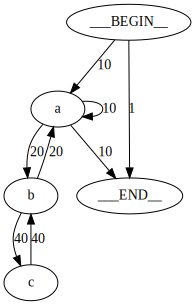

a a b c b c b c b a a b c b c b c b a a b c b a b a b c b a a b c b a b c b c b c b c b a b c b c b a b c b c b c b a b c b c b a b c b c b c b c b c b a
-1 model:


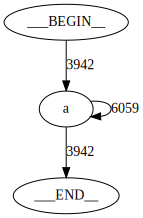

a a a
a a
a a
a a a a a
a a a
a a
a
a
a a a
a
a
a a a a
a
a a a a a a


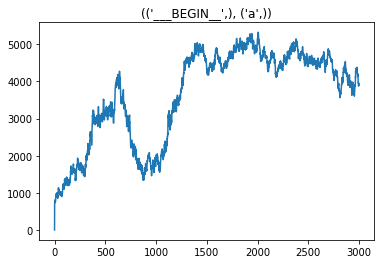

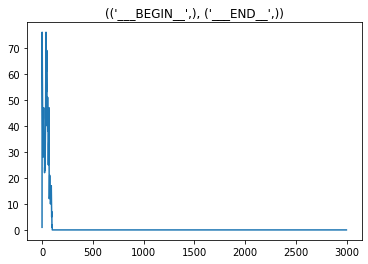

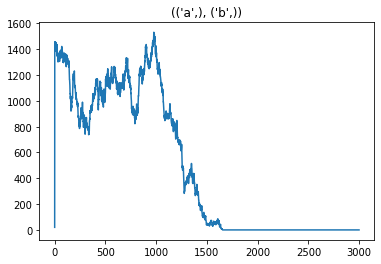

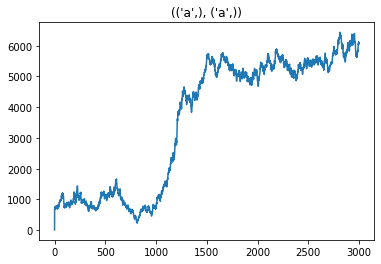

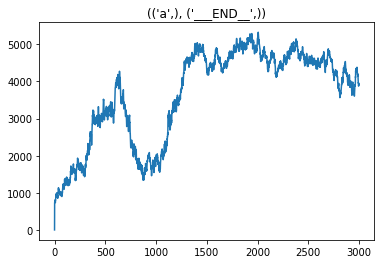

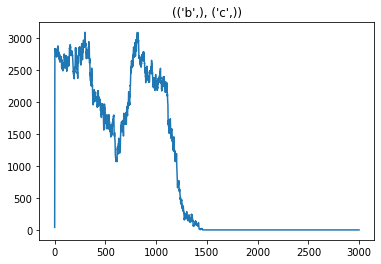

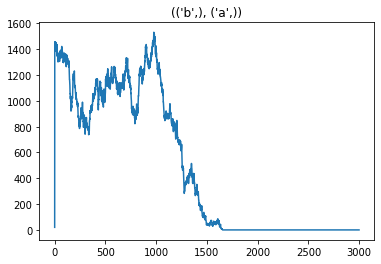

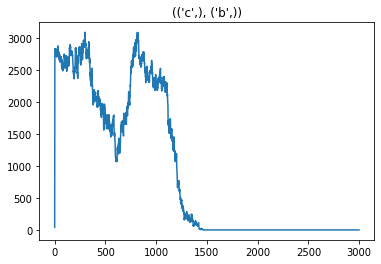

In [46]:
random.seed(5) # make deterministic
# shakespeare data from https://www.kaggle.com/kingburrito666/shakespeare-plays?select=alllines.txt
#with open("alllines.txt", "r") as f:
#    text = f.read()
text = (("a b c b c b a "*2) + "\n")*10
datas = [a.split() for a in text.split("\n")]
config = Config(tokensFromOriginalModel=0)
# USE runExperiment INSTEAD OF runAndVisualizeExperiment WHEN YOU DO shakespeare,
# OTHERWISE DOT WILL CRASH YOUR COMPUTER BECAUSE THE FIRST BIGRAM MODEL IS 80,000 NODES,
# ALSO THERE WILL BE TOO MANY EDGES AND NOTEBOOK WILL GET VERY LARGE
# models = runExperiment(initialDataset=datas, numSteps=10000, contextSize=1, maxSampleLen=100, minTotalGeneratedTokens=10000, debug=True)
# runAndVisualize is safe for toy stuff
models = runAndVisualizeExperiment(config, initialDataset=datas, printRange=[0, -1], numSteps=3000, contextSize=1, maxSampleLen=100, minTotalGeneratedTokens=10000, debug=True)

In [ ]:
random.seed(5) # make deterministic
# shakespeare data from https://www.kaggle.com/kingburrito666/shakespeare-plays?select=alllines.txt
with open("alllines.txt", "r") as f:
    text = f.read()
#text = (("a b c b c b a "*2) + "\n")*10
datas = [a.split() for a in text.split("\n")]
# momentum of 0.1 means that we are 0.1 prevModel and 0.9 nextModel
config = Config(tokensFromOriginalModel=2000, momentum=0.1, storeHistory=False)
# USE runExperiment INSTEAD OF runAndVisualizeExperiment WHEN YOU DO shakespeare,
# OTHERWISE DOT WILL CRASH YOUR COMPUTER BECAUSE THE FIRST BIGRAM MODEL IS 80,000 NODES,
# ALSO THERE WILL BE TOO MANY EDGES AND NOTEBOOK WILL GET VERY LARGE
models3 = runExperiment(config, initialDataset=datas, numSteps=10000, contextSize=1, maxSampleLen=100, minTotalGeneratedTokens=10000, debug=True)
# runAndVisualize is safe for toy stuff
#models2 = runAndVisualizeExperiment(config, initialDataset=datas, printRange=[0, -1], numSteps=3000, contextSize=1, maxSampleLen=100, minTotalGeneratedTokens=10000, debug=True)

0 10000 80365 0.0
1 10000 80365 0.0032447142910351757
2 10000 80365 0.009892293882273737
3 10000 80365 0.015008479594793173
4 10000 80365 0.01689898161413996
5 10000 80365 0.018087693466504233
6 10000 80365 0.019018944285278703
7 10000 80365 0.02000878170672629
8 10000 80365 0.02097070801049006
9 10000 80365 0.0217515713825964
10 10000 80365 0.022530033217494617
11 10000 80365 0.023339595693758364
12 10000 80365 0.02417378315430694
13 10000 80365 0.024897393367115734
14 10000 80365 0.025649798998149478
15 10000 80365 0.026411356095539747
16 10000 80365 0.027113961995419704
17 10000 80365 0.027766397979781563
18 10000 80365 0.028371404908093506
19 10000 80365 0.029024622258142067
20 10000 80365 0.029559162283887015
21 10000 80365 0.030078259625942398
22 10000 80365 0.030664083090007916
23 10000 80365 0.031212054454596808
24 10000 80365 0.031792544715016156
25 10000 80365 0.03230204132452893
26 10000 80365 0.03282945308433841
27 10000 80365 0.033332145989081234
28 10000 80365 0.033793695

230 10000 80365 0.06657094200086905
231 10000 80365 0.06665079744696237
232 10000 80365 0.066723436462709
233 10000 80365 0.06677470013946069
234 10000 80365 0.06680576362803622
235 10000 80365 0.0668390781942107
236 10000 80365 0.0668949281560267
237 10000 80365 0.06692555152450534
238 10000 80365 0.06697447082265517
239 10000 80365 0.0670397248588365
240 10000 80365 0.06705530875687193
241 10000 80365 0.06711634060726578
242 10000 80365 0.0671715091107909
243 10000 80365 0.06721561797003192
244 10000 80365 0.06726095814106453
245 10000 80365 0.06731144028990671
246 10000 80365 0.06736857794469636
247 10000 80365 0.06742687158237165
248 10000 80365 0.06747581437606505
249 10000 80365 0.06750565092613357
250 10000 80365 0.06752959764930386
251 10000 80365 0.06757344833650467
252 10000 80365 0.06761475662444477
253 10000 80365 0.06768162260985261
254 10000 80365 0.06773375721267849
255 10000 80365 0.06774784267341608
256 10000 80365 0.0677982035715881
257 10000 80365 0.06783285110619627

459 10000 80365 0.07017670968400286
460 10000 80365 0.07014791788184142
461 10000 80365 0.07014410390722337
462 10000 80365 0.07012448533687382
463 10000 80365 0.07013075180965768
464 10000 80365 0.07015784777377253
465 10000 80365 0.07017380794023964
466 10000 80365 0.07017437439294116
467 10000 80365 0.07014496968649526
468 10000 80365 0.07014635660859735
469 10000 80365 0.07015259131505344
470 10000 80365 0.07014510895059592
471 10000 80365 0.07014864246451243
472 10000 80365 0.07016399967857682
473 10000 80365 0.07020045876951171
474 10000 80365 0.0702095760386862
475 10000 80365 0.07021789472741499
476 10000 80365 0.07021310056131329
477 10000 80365 0.07022597339569372
478 10000 80365 0.07022526316223718
479 10000 80365 0.07022130389472898
480 10000 80365 0.07022618901102702
481 10000 80365 0.07021763238586591
482 10000 80365 0.07023357715689495
483 10000 80365 0.07025851623386112
484 10000 80365 0.07025115375760531
485 10000 80365 0.07024320962486054
486 10000 80365 0.07022600954

688 10000 80365 0.0703027031554405
689 10000 80365 0.07028564506925913
690 10000 80365 0.07030200305237058
691 10000 80365 0.07026767347468098
692 10000 80365 0.07027922839935119
693 10000 80365 0.07030129284113214
694 10000 80365 0.07032420399822126
695 10000 80365 0.07032728957958777
696 10000 80365 0.07033854625157611
697 10000 80365 0.0703082473225609
698 10000 80365 0.0703063129955696
699 10000 80365 0.07030188355771676
700 10000 80365 0.07030528516061725
701 10000 80365 0.07029055917586281
702 10000 80365 0.07029138368796224
703 10000 80365 0.07028279106972549
704 10000 80365 0.07027078549049955
705 10000 80365 0.0702575418297136
706 10000 80365 0.07028021893092887
707 10000 80365 0.07026940752212987
708 10000 80365 0.07025651831232715
709 10000 80365 0.07022816839915096
710 10000 80365 0.0702191031063948
711 10000 80365 0.07024108449307608
712 10000 80365 0.0702180274138207
713 10000 80365 0.07023346594427532
714 10000 80365 0.07021486709639943
715 10000 80365 0.0701855219100527

917 10000 80365 0.07030935296278765
918 10000 80365 0.07026816683080349
919 10000 80365 0.0702656230642733
920 10000 80365 0.07026112588508625
921 10000 80365 0.0703056162816987
922 10000 80365 0.07030639105903395
923 10000 80365 0.07031480745220979
924 10000 80365 0.07034325143833059
925 10000 80365 0.07037841745060659
926 10000 80365 0.07035700196054716
927 10000 80365 0.07037654621013802
928 10000 80365 0.0703610816279427
929 10000 80365 0.0703941287290098
930 10000 80365 0.07039377318494389
931 10000 80365 0.07040072801489343
932 10000 80365 0.07038355787394654
933 10000 80365 0.07038969868240053
934 10000 80365 0.07037320134852902
935 10000 80365 0.07038306447571036
936 10000 80365 0.07038701285147066
937 10000 80365 0.07041498162359341
938 10000 80365 0.0704372166210198
939 10000 80365 0.07045637463344352
940 10000 80365 0.07045055650057126
941 10000 80365 0.07045851951049457
942 10000 80365 0.07044661839964797
943 10000 80365 0.0704568871453449
944 10000 80365 0.0704700622623565

1142 10000 80365 0.07019676063970613
1143 10000 80365 0.07019253429503398
1144 10000 80365 0.07020458855275864
1145 10000 80365 0.07020308611482562
1146 10000 80365 0.07020617696476769
1147 10000 80365 0.07020371172421588
1148 10000 80365 0.0702123557177913
1149 10000 80365 0.07020510631692291
1150 10000 80365 0.07019389815806303
1151 10000 80365 0.07019832924011159
1152 10000 80365 0.07016743982885268
1153 10000 80365 0.07016191756136231
1154 10000 80365 0.07016435687473346
1155 10000 80365 0.07016292826188072
1156 10000 80365 0.07018407953994313
1157 10000 80365 0.07021173064877499
1158 10000 80365 0.07021528428362764
1159 10000 80365 0.07021867857996916
1160 10000 80365 0.0702036106016833
1161 10000 80365 0.07021384776320448
1162 10000 80365 0.0702022001542054
1163 10000 80365 0.07019717876258462
1164 10000 80365 0.0702213209397451
1165 10000 80365 0.07023042481339152
1166 10000 80365 0.07022837181495283
1167 10000 80365 0.07023390208123882
1168 10000 80365 0.07021207189008725
1169 

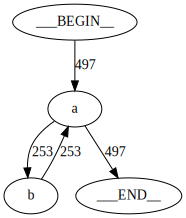

In [23]:
# how to visualize any model in the history
# (warning: don't visualize early models when using large datasets,
# examine len of the model first and make sure it's not more than a few thousand)
display(modelToDot(models[600]))

In [17]:
# how to generate text from any model in the history
" ".join(list(models[-1].gen()))

'"By being miss\'d, I will not wish thee apart Cousin of duty,"'